In [114]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import nibabel as nib
import pandas
from matplotlib import cm

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pyvista as pv

In [139]:
FONT_TITLE_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'bold',
                   'fontsize': 14}

FONT_LABEL_PLOT = {'family': 'sans-serif',
                   'color':  'black', 
                   'fontweight': 'normal',
                   'fontsize': 12}

FONT_LEGEND_PLOT = {'family': 'sans-serif',
                    'color':  'black', 
                    'fontweight': 'normal',
                    'fontsize': 12}

# Data import and partition

## Preprocessed data import
The data have already been preprocessed using the matlab class PSM (using the generateExportData function). Dataset with voxel size from 500 um to 2000 um have been generated and are located in in the folder "../../03_Data/"

In [150]:
# Load vectorized VTA matrix
dataset = scipy.io.loadmat('../../03_Data/ML_datasets/trilinear_interpolation/dataset_1100um.mat')

table = pandas.read_csv('table.csv')

amp = table['amplitude']
X = np.clip(np.array(dataset['X']), 0, 1)
y = np.squeeze(np.array(dataset['y']))
CONTAINER_AFFINE = np.squeeze(np.array(dataset['container_affine']))
CONTAINER_SHAPE = np.squeeze(np.array(dataset['container_shape']))

X = np.hstack([X, np.expand_dims(amp.to_numpy(), axis=0).T])



# Create partitions of training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=23)

scaler = StandardScaler().fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

print("min_test = ", np.argmin(X_test[:, :-1]))
print("max_test = ", np.argmax(X_test[:, :-1]))
# ISSUE: the standard scaler does not work

newrow1 = np.ones((1, X.shape[1]))
newrow0 = np.zeros((1, X.shape[1]))
newrow0[0, 0] = 1

print("Number of features:    n = ", np.sum(np.max(X_train, axis=0), axis=0))


min_test =  1
max_test =  0
Number of features:    n =  1547.115436212372


In [151]:
# Load STN polygon
pv.set_jupyter_backend('panel')
reader = pv.get_reader('templates/anatomyDISTALminimal.ply')
STN = reader.read()

# Plot functions

Before going into the generation of the maps, this section creates function useful to observe and compare the probabilistic maps.

### Reconstruction of a VTA
As the data (the VTA voxels values) are provided under a vectorized form, it is necessary to be able to reconstruct the map. The first feature of the matrix is the intercept term and is cannot be displayed with the rest of the map voxels.

In [200]:
def logit(x):
    eps = 1e-3
    return np.log((x+eps)/(1-x+eps))

def invlogit(x):
    return np.exp(x)/(1+np.exp(x))

def normalize(arr):
    arr_min = np.min(arr)
    return (arr-arr_min)/(np.max(arr)-arr_min)

def show_histogram(image):

    # Create the histogram
    histogram, bin_edges = np.histogram(image, bins=256, range=(0, 1))

    # Configure and draw the histogram figure
    plt.figure()
    plt.title("Grayscale Histogram")
    plt.xlabel("grayscale value")
    plt.ylabel("pixels")
    plt.xlim([0.0, 1.0])
    plt.plot(bin_edges[0:-1], histogram)
    plt.show()

def reconstruct(vector):
    # Function to reconstruct a tensor (3D image) from the vectorized image based on the container shape

    intercept = vector[0]
    amplitude_coeff = vector[-1]
    vector = vector[1:-1]


    tensor = np.reshape(vector, CONTAINER_SHAPE, order='F')

    return tensor, intercept

def homogeneous_transform(coord, transform, isvector=0):
    # Apply transform to the points array p0
    # [p1 1]^T = M x [p0 1]^T

    if isvector:
        coord = np.concatenate((coord, np.zeros((1, coord.shape[1]))), axis=0)
    else:
        coord = np.concatenate((coord, np.ones((1, coord.shape[1]))), axis=0)

    transformed_coord = transform @ coord

    return transformed_coord[0:3, :].T

def mat2pcd(tensor, threshold=1e-2, transform=CONTAINER_AFFINE):

    # Get all indices of the tensor image and create a Nx3 coordinates array
    xx, yy, zz = np.indices(np.array(tensor.shape))
    coord = [xx.flatten(), yy.flatten(), zz.flatten()]

    # Get the Nx1 image values array
    values = tensor[coord]

    points = homogeneous_transform(np.vstack(coord), transform)
    todelete = np.argwhere(np.abs(values) < threshold)

    values = np.delete(values, todelete, axis=0)
    points = np.delete(points, todelete, axis=0)

    pcd = pv.PolyData(points)
    data = values
    #print(points.shape)
    #print(data.shape)

    # Add that data to the mesh with the name "uniform dist"
    pcd["coef"] = values

    return pcd

## Map plot
The plots of the map shall allow the vizualization of the map inside the MNI space. It is  important that the plot are easy to understand in order to give better insights about the stimulation sweet and sour spots. The function plot maps allows to plot the map in 3D (scatter) or see it in 2D as a image. In both cases the surrounding anatomy is displayed.

In [153]:
def plot_map(coef,
             dim='2D', 
             plane='axial',
             slice_index=int(CONTAINER_SHAPE[0]/2),
             view_angle=320, 
             markersize=5,
             dispthreshold=1e-2):

    print(markersize)
    coef_tensor, coef_intercept = reconstruct(coef)

    if dim == '2D':
        plot_slice(coef_tensor, slice_index, plane)
        
    elif dim == '3D':
        return plot_volume(coef_tensor, view_angle, markersize, dispthreshold)

def plot_slice(tensor, slice_index, plane):
    # Function to plot a slice of the map on a 2D figure
    
    fig = plt.figure(figsize=(25/2.54, 25/2.54))
    ax = plt.axes()
    plt.ion()
    plt.set_cmap('seismic')

    if plane == 'axial':
        img = tensor[:, :, slice_index]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'sagittal':
        img = tensor[:, slice_index, :]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Medial-lateral (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    elif plane == 'coronal':
        img = tensor[slice_index, :, :]
        max_img = np.max(np.abs(img))
        plt.pcolor(img, vmin=-max_img, vmax=max_img)
        plt.colorbar()
        ax.set_xlabel('Posterior-anterior (mm)', fontdict=FONT_LABEL_PLOT)
        ax.set_ylabel('Inferior-superior (mm)', fontdict=FONT_LABEL_PLOT)
        
    plt.show()

def plot_volume(cube, view_angle, markersize, threshold):

    cmap = plt.cm.get_cmap("seismic", 20)
    map_pcd = mat2pcd(cube, threshold)

    plotter = pv.Plotter(window_size=(500, 500))
    plotter.add_mesh(STN,
                     label='STN',
                     color='white',
                     opacity=0.6)
    plotter.add_points(map_pcd,
                       cmap=cmap,
                       point_size=markersize)
    plotter.add_legend()
    plotter.set_background('white')
    plotter.renderer.add_axes(interactive=None, line_width=2, color=None, x_color='blue', y_color='green', z_color='red', xlabel='X', ylabel='Y', zlabel='Z', labels_off=False)
    plotter.show()
    #plotter.screenshot(filename='./airplane.png')


## Results plot
The results plot will be used in order to assess the quality of a model. It includes:
   - Prediction vs ground truth on testing set,
   - Prediction vs ground truth on training set,
   - Coefficient of determination of between variable prediction and ground truth,
   - Residual plot and QQ plot of those.

In [202]:
# Function used to visualize the accuracy of a model on testing and training data
def plot_results(model, X_test, y_test, X_train, y_train, transformed=False):

    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)

    if transformed:
        pred_test = invlogit(pred_test)
        pred_train = invlogit(pred_train)
        coef_deter_test = model.score(X_test, logit(y_test))
        coef_deter_train = model.score(X_train, logit(y_train))

    else:
        coef_deter_test = model.score(X_test, y_test)
        coef_deter_train = model.score(X_train, y_train)

    adj_coef_deter_test = 1-(1-coef_deter_test)*(X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)
    adj_coef_deter_train = 1-(1-coef_deter_train)*(X_train.shape[0]-1)/(X_train.shape[0]-X_train.shape[1]-1)

    # Create figure and axes
    fig, axs = plt.subplots(1, 2)

    # Set figure size and name
    fig.tight_layout()
    fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
    fig.set_size_inches(25/2.54, 25/2.54)

    # Set axe properties
    axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
    axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[0].scatter(pred_test, y_test, s=8)
    axs[0].set_aspect('equal', 'box')

    axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
    axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
    axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
    axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
    axs[1].scatter(pred_train, y_train, s=8)
    axs[1].set_aspect('equal', 'box')

    if False:# transformed:
        axs[0].set_xlim([-0.05, 1.05])
        axs[0].set_ylim([-0.05, 1.05])

        axs[1].set_xlim([-0.05, 1.05])
        axs[1].set_ylim([-0.05, 1.05])

    # Show figure
    plt.show()

    # Print the value of the R2
    print("Coefficient of determination (R²):")
    print("     - testing  :    ", coef_deter_test)
    print("     - training :    ", coef_deter_train)


## Export map

In [203]:
def save_map(model):
    ni_img = nib.Nifti1Image(reconstruct(model.coef_)[0], CONTAINER_AFFINE)
    nib.save(ni_img, 'map.nii.gz')

# Probabilistic Stimulation for deep brain stimulation

## N-Image

In [204]:
STN_nii = nib.load('./templates/STN.nii.gz')
STN_pcd = mat2pcd(STN_nii.get_fdata(), threshold=1e-2, transform=STN_nii.affine)
STN = STN_pcd.delaunay_3d(progress_bar=True)


Computing 3D Triangulation: 100%|██████████[00:05<00:00]


In [205]:
n_image = np.sum(X, axis=0)
plot_map(n_image, dim='3D', markersize=5, dispthreshold=2)

5


5


5


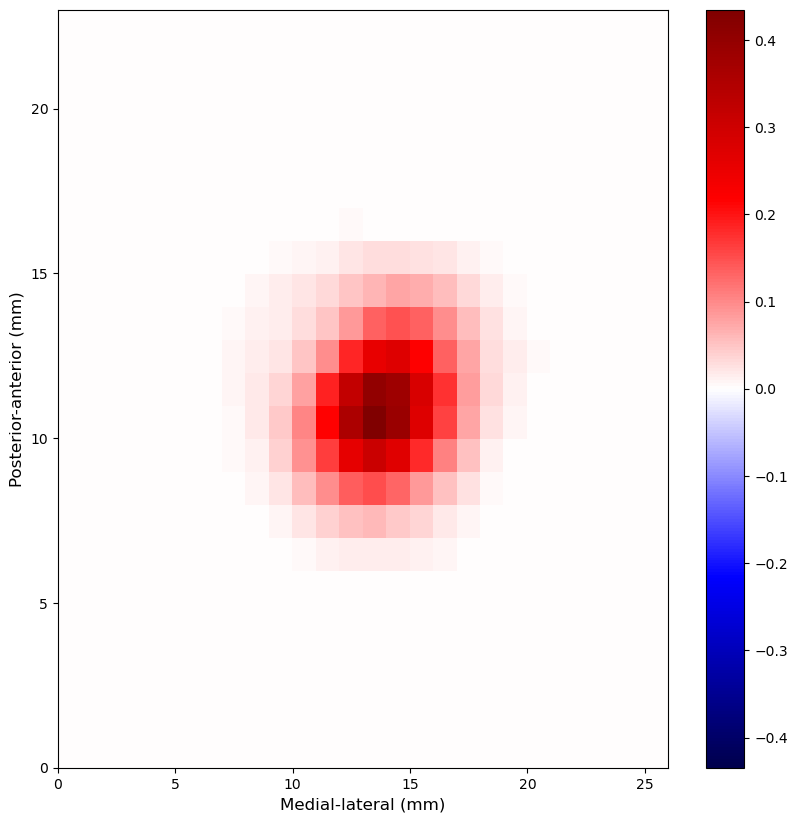

In [206]:
mean_image = np.mean(X * y[np.newaxis, :].T, axis=0)
plot_map(mean_image, dim='3D')
plot_map(mean_image, dim='2D')

## Linear Models
### Linear regression (response variable in unit interval)
Both linear regression (with response variable in unit interval or real numbers) show the typical signs of overfiting. The training accuracy is very high and generalize very poorly. The map also shows that the learned parameters completely ignored the regions stimulated by a lot of VTAs and gives more importance to the surrounding voxels stimulated by less voxels.

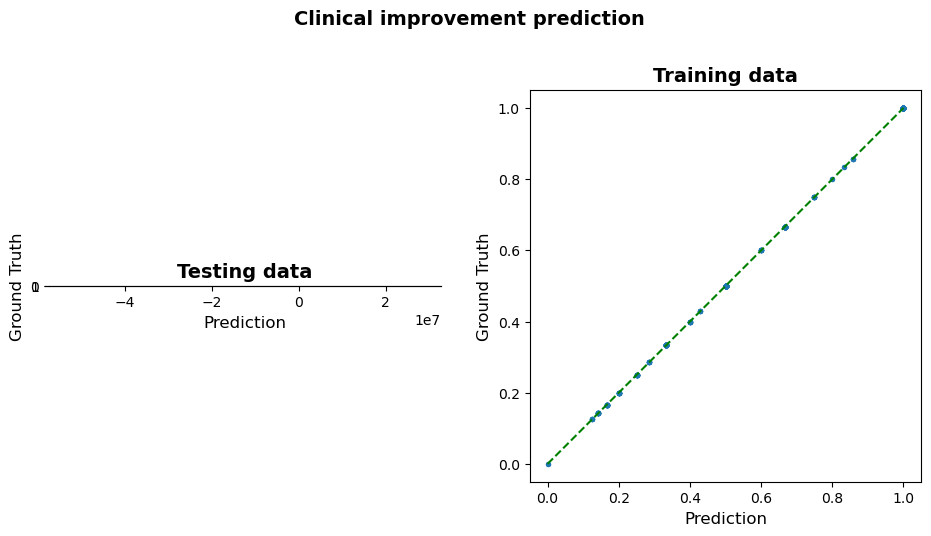

Coefficient of determination (R²):
     - testing  :     -521592287271355.1
     - training :     0.9999999999953504
5


5


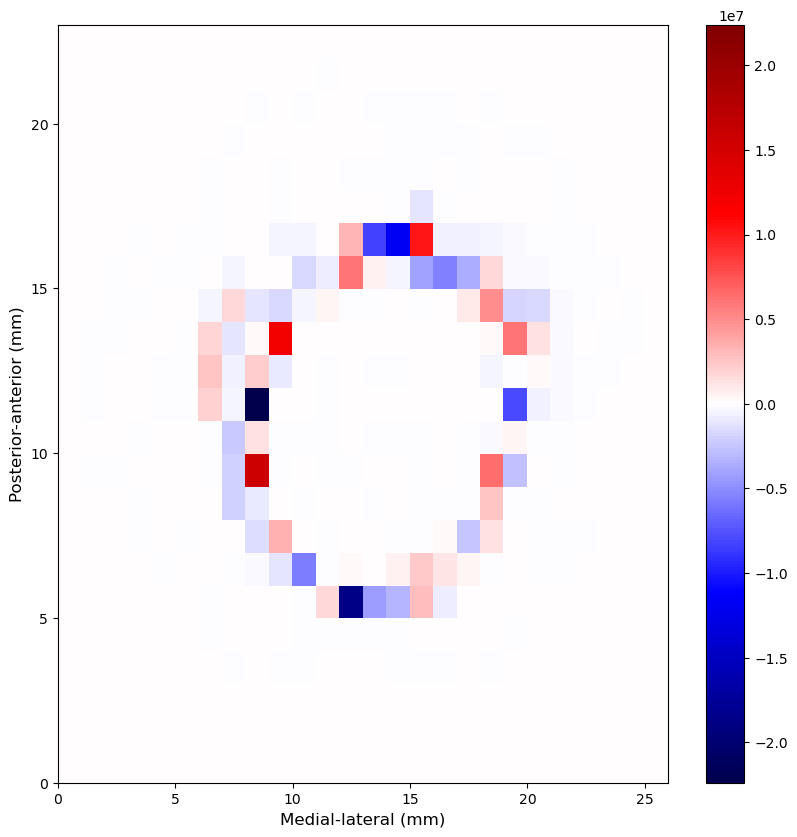

In [207]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, y_train)

plot_results(model, X_test, y_test, X_train, y_train, transformed=False)
plot_map(model.coef_, dim='3D', dispthreshold=0.2)
plot_map(model.coef_, dim='2D')

### Linear regression (response variable transformed in real positive)

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in exp
  
/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in true_divide
  


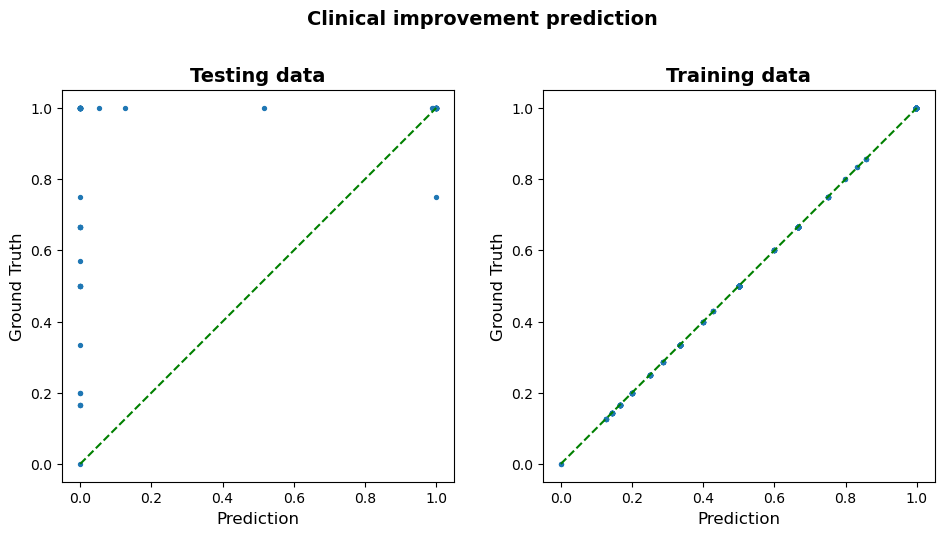

Coefficient of determination (R²):
     - testing  :     -607629282420419.8
     - training :     0.9999999999930897
5


5


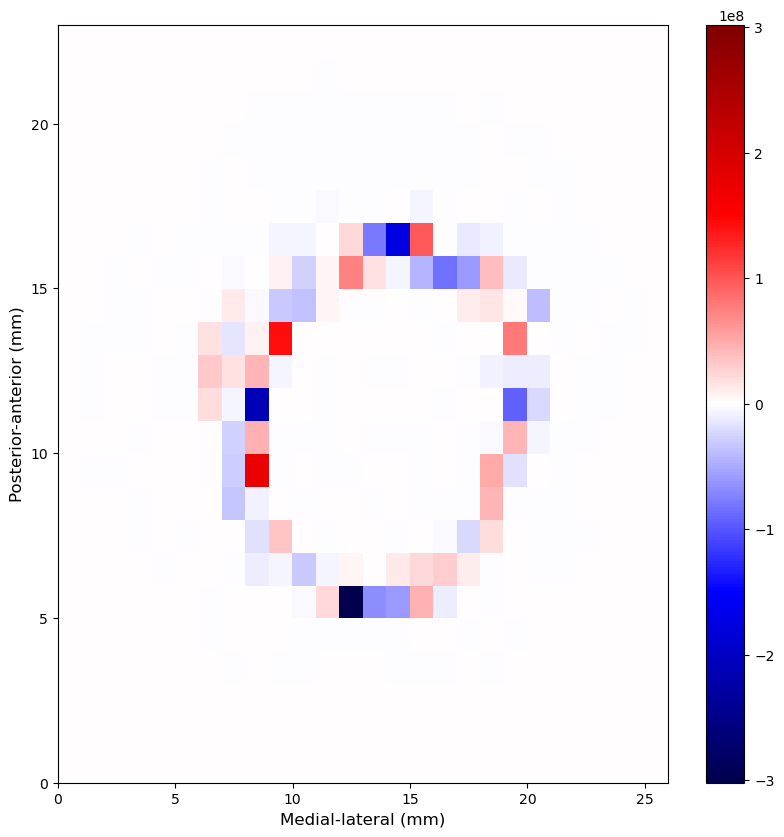

In [208]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model = model.fit(X_train, logit(y_train))

plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model.coef_, dim='3D')
plot_map(model.coef_, dim='2D')

### Bayesian Linear regression

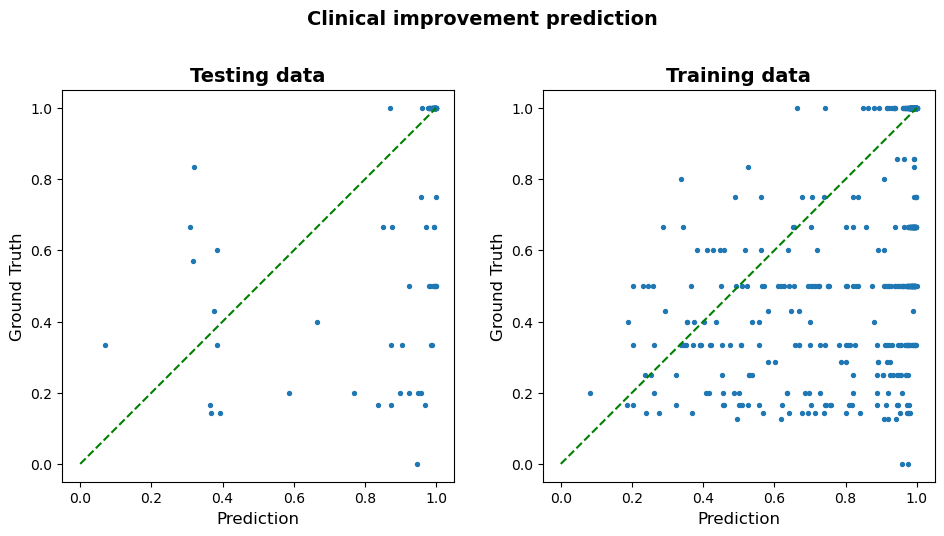

Coefficient of determination (R²):
     - testing  :     0.39232345016389947
     - training :     0.49215314843697366
10


5


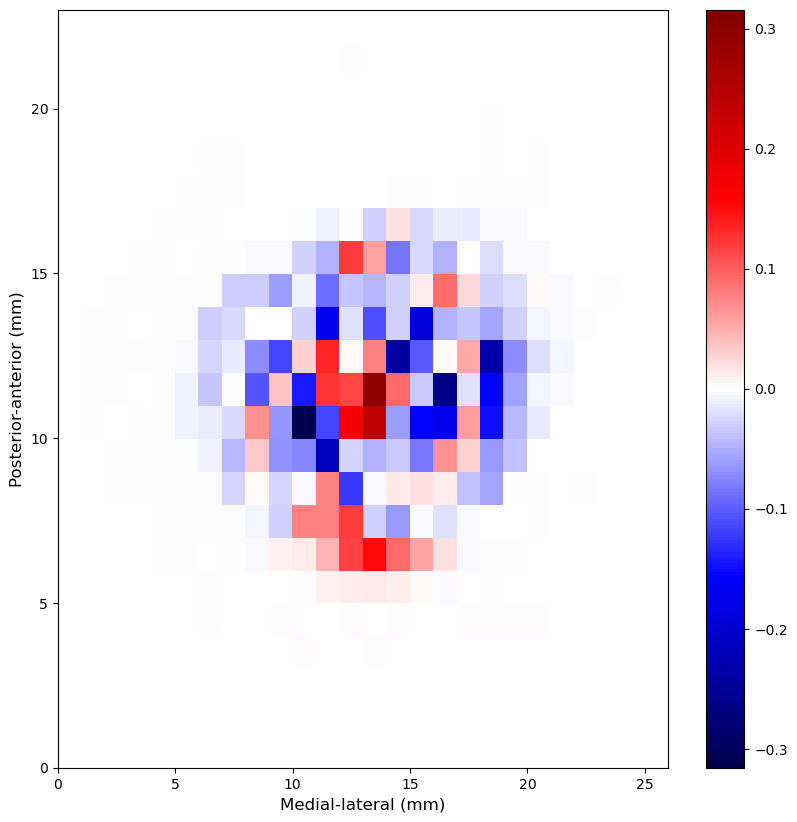

In [209]:
from sklearn.linear_model import BayesianRidge

model = BayesianRidge(alpha_1=1e-1, alpha_2=1e-3, lambda_1=1e-3, lambda_2=1e-3)
model.fit(X_train, logit(y_train))
plot_results(model, X_test, y_test, X_train, y_train, transformed=True)
plot_map(model.coef_, dim='3D', markersize=10, dispthreshold=0.05)
plot_map(model.coef_, dim='2D')

### Lasso regression

[  0.52939931   6.11206229   2.69767497   4.85449169   5.74479633
 -10.06996192   6.88525377   6.60451137  -0.03509591   0.86098389
  12.21969495  -0.39259649   5.63713865   1.64765891   5.44150953
   7.51370559   6.78876545   1.26405365   5.20608921   5.51729032
   5.73927662   9.2758902    3.41461156   3.71252338   5.83894579
   5.20272654   5.55680327   3.7467555    3.98877362   4.77600879
   5.38085746   1.52147344  -8.71378925   5.26991331   1.68489612
   5.12257499   3.38452171   4.44825584  -0.71699713   4.04651298
   8.60630855   3.42287059  16.39643781   6.28233102   1.17849147
   7.91078184   6.76685228  -0.05871294   3.74742568   8.2966557
   2.78594479   4.85151667   5.78339131   1.00693211   5.01594217
   6.58289559   7.11335637   7.59854984   5.05271541   1.58904087
   4.95868754   5.38841003   4.16211868   5.41484181   4.22367357
  -1.26126136   1.93511778   6.02107852   4.81536086   5.67834669
   5.11077961   3.18607491   6.10321062   6.10966254 -10.35285771
   0.861613

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 10.336188088293056, tolerance: 1.0806722593286253
  positive)


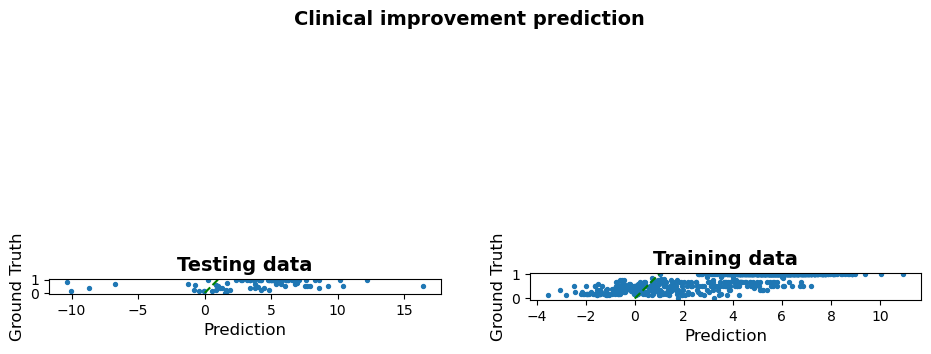

Coefficient of determination (R²):
     - testing  :     -255.95191061348254
     - training :     -187.51526969907195
5
Intercept coefficient =  0.0
Amplitude coefficient =  1.9513648335013756
[[ 0.  0.  0. ... 16. 16. 16.]
 [ 0.  0.  0. ... 18. 18. 18.]
 [ 0.  1.  2. ... 17. 18. 19.]
 [ 1.  1.  1. ...  1.  1.  1.]]


5
Intercept coefficient =  0.0
Amplitude coefficient =  1.9513648335013756


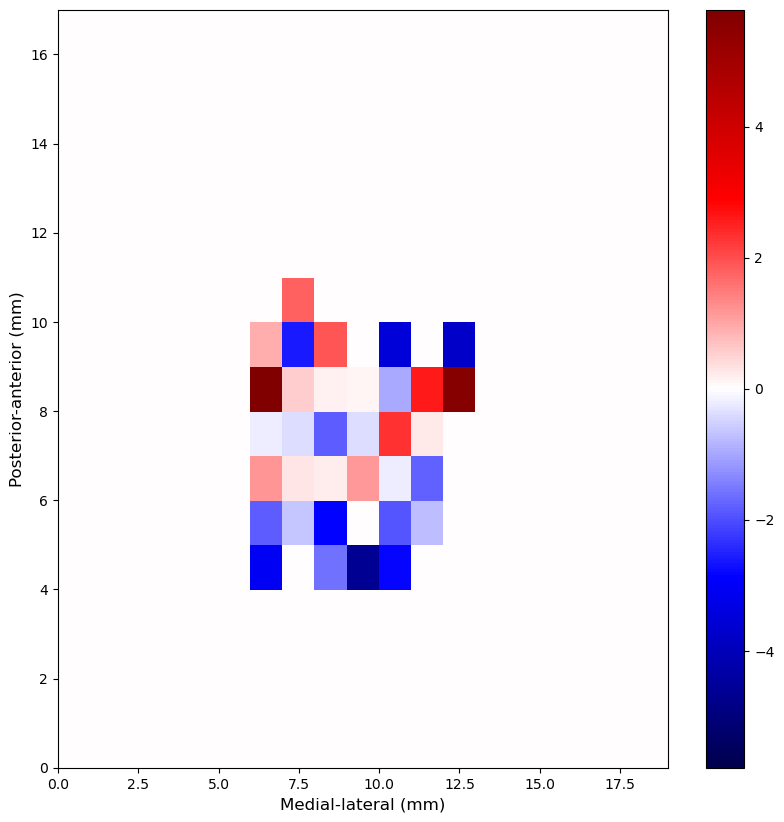

In [33]:
from sklearn.linear_model import Lasso

model = Lasso(alpha=0.0008, random_state=0)
model = model.fit(X_train, logit(y_train))
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)
plot_map(model.coef_, dim='3D')
plot_map(model.coef_, dim='2D')

### Elastic Nets

[ 3.05075410e-01  7.38269902e-01  9.28184647e-01  7.18782681e-01
  7.18670344e-01  5.70544652e-01  8.77955795e-01  9.55641360e-01
  2.20971759e-02 -6.54617758e+21  6.63703493e-01  4.53843492e-01
  9.52178541e-01  6.38751811e-01  1.16395535e+00  9.88906380e-01
  8.85585748e-01  4.47174300e-01  1.02768807e+00  1.14324088e+00
  8.68606896e-01  1.04673483e+00  6.66977030e-01  7.65214500e-01
  1.01685587e+00  8.36111197e-01  1.27072843e+00  1.76210487e+00
  8.03303647e+07  8.70672953e-01  9.38429948e-01  7.28630724e-01
 -3.04299053e-01  9.13376625e-01  6.11659539e-01  9.03824454e-01
  9.15070885e-01  2.16863461e+03  5.19508947e-01  1.43596655e+02
  1.22065587e+00  8.19315251e-01  4.77174313e+02  8.93717516e-01
  4.73566388e-01  7.74069481e-01 -7.93755122e-01  5.31695202e-01
  7.71982433e-01  1.04791886e+00  8.59585083e-01  3.94510874e-01
  8.03323069e-01  7.64383038e-01  8.47153822e-01  1.25895301e+00
  8.53951110e-01  1.02049595e+00  9.88992099e-01  8.28397938e-01
 -5.07458450e-01  9.62191

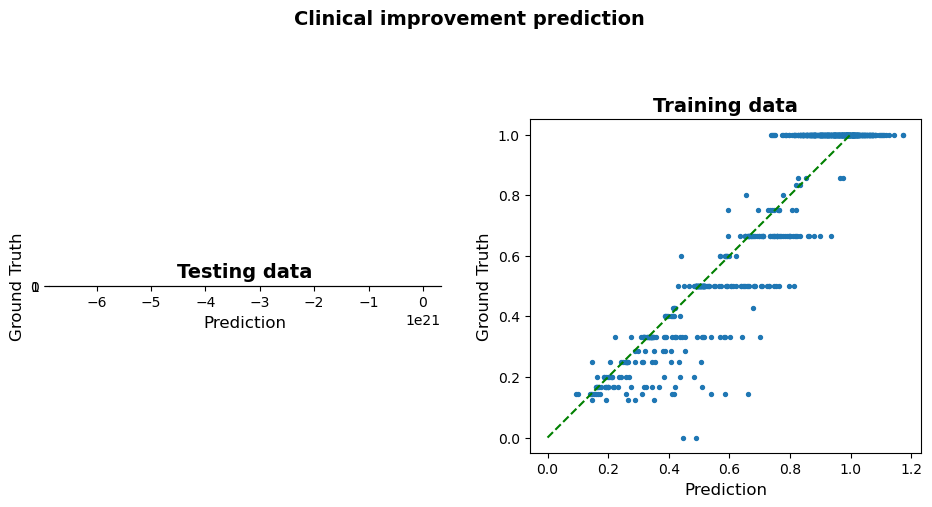

Coefficient of determination (R²):
     - testing  :     -4.439491128584361e+42
     - training :     0.8940097639791653
5
Intercept coefficient =  0.0
Amplitude coefficient =  0.2315285949660831


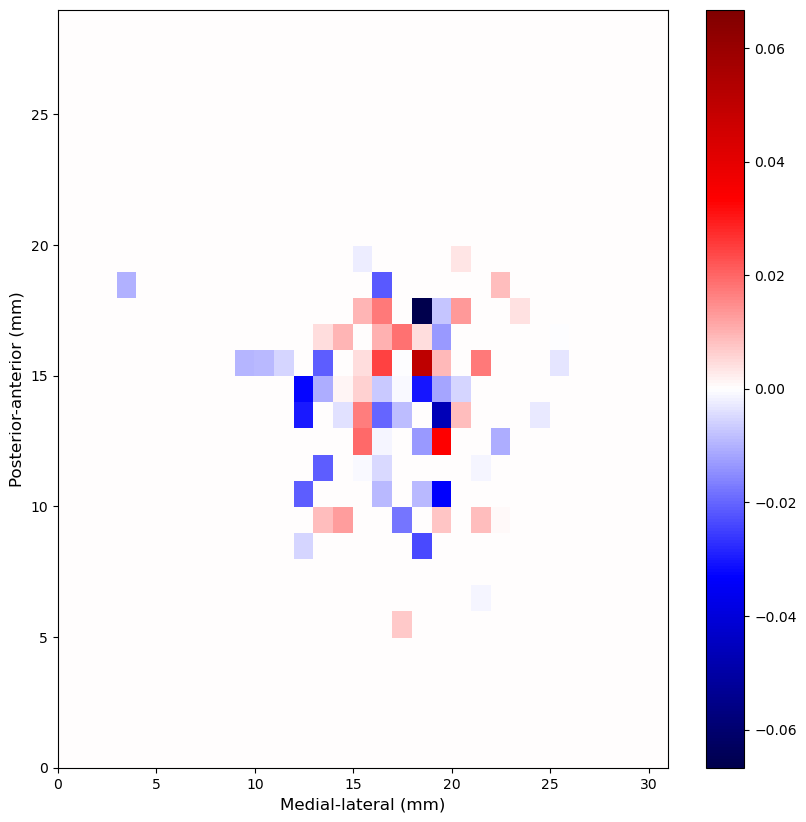

5
Intercept coefficient =  0.0
Amplitude coefficient =  0.2315285949660831
[[ 0.  0.  0. ... 28. 28. 28.]
 [ 0.  0.  0. ... 30. 30. 30.]
 [ 0.  1.  2. ... 29. 30. 31.]
 [ 1.  1.  1. ...  1.  1.  1.]]


In [137]:
from sklearn.linear_model import ElasticNet

model = ElasticNet(random_state=43, alpha=0.005, l1_ratio=0.1, max_iter=10000)
model = model.fit(X_train, (y_train))

plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.coef_, dim='2D')
plot_map(model.coef_, dim='3D')

## Generalized Linear Models
### Logistic Regression
Cannot be used with a continuous response variable because it relies on the Bernoulli distribution which is not applicable to a continuous variable as the clinical improvement. But by rounding the response variable to a binary outcome in the training set and then evaluating the probability of the response against the continuous test response it is possible to use this model

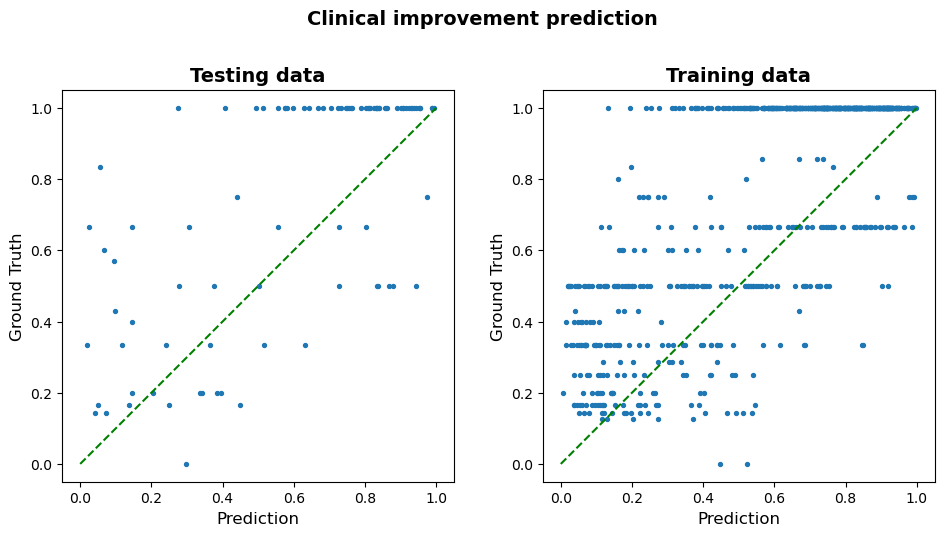

Coefficient of determination (R²):
     - testing  :     0.4660026350366903
     - training :     0.5663446230206766
5


In [217]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=10000, tol=1e-9, C=0.08, penalty='l2', dual=True, solver='liblinear', class_weight='balanced')
model = model.fit(X_train, np.round(y_train).astype('int'))
a = np.round(y_train)
pred_test = model.predict_proba(X_test)
pred_train = model.predict_proba(X_train)

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test[:, 1], y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train[:, 1], y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test[:, 1], y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train[:, 1], y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

plot_map(model.coef_.T, dim='3D')


### Beta Regression

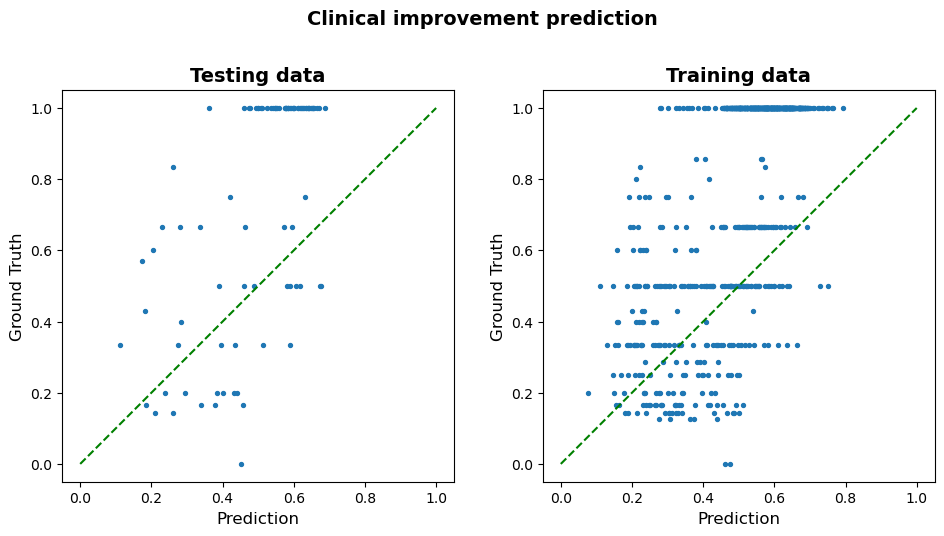

Coefficient of determination (R²):
     - testing  :     0.39257525857071834
     - training :     0.47878397498566305
Number of features selected:   n =  100


In [214]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params, C=2, C1_ratio=0.2):
    return C * C1_ratio * np.linalg.norm(params, ord=1, axis=0) + C * (1 - C1_ratio) * np.linalg.norm(params, ord=2, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

# feature_selection = VarianceThreshold()
feature_selection = PCA(n_components=100)
feature_selection = feature_selection.fit(X_train)

X_train_selected_feat = feature_selection.transform(X_train)
X_test_selected_feat = feature_selection.transform(X_test)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
pred_train = expit(np.dot(X_train_selected_feat, b))             # prediction
pred_test = expit(np.dot(X_test_selected_feat, b))             # predictions

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test, y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train, y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test, y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train, y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

# Print the value of the R2
print("Number of features selected:   n = ", X_train_selected_feat.shape[1])

### Tweedie Regression

[0.32134662 0.85233411 0.8233025  0.93472105 0.70994124 0.3631944
 0.99993433 1.03668566 0.27702682 0.38771479 1.06329773 0.66035308
 0.98964451 0.6126837  0.96656276 0.88315844 1.00188292 0.40237644
 1.23285049 0.91096558 0.88699976 1.08272535 0.69172264 0.74864585
 0.94987287 0.79708437 0.98195417 1.03908667 0.34641711 0.79527921
 0.37748727 0.54840269 0.21703397 1.02000192 0.60458304 0.90729774
 1.09604435 0.40081423 0.25160481 0.59943187 0.69217718 0.63195089
 0.995523   0.63410701 0.41420255 1.10353654 0.57295733 0.42389828
 0.66835002 0.94509211 0.89396753 0.31303371 0.93901975 0.65972093
 0.8379741  1.07271065 1.14211859 1.08303691 0.94337242 0.6025302
 0.90778872 1.03703493 0.87354241 0.74058215 1.01252193 0.54776893
 0.60937575 0.97232885 1.02453753 1.12898741 0.76554371 0.89507224
 1.03005035 1.08077811 0.31966287 0.56619768 0.79041576 0.96021443
 1.40784653 1.01560862 1.11032571 1.09049906 0.96490467 0.72652915
 0.60446178 0.57636531 0.7327757  1.28342171 1.28848494 0.701524

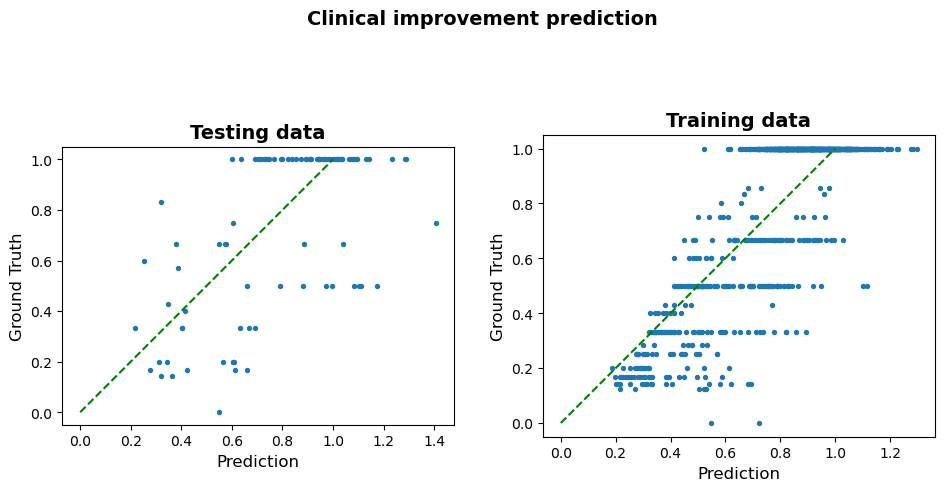

Coefficient of determination (R²):
     - testing  :     0.27920895146966396
     - training :     0.6403871157855847


In [199]:
from sklearn.linear_model import TweedieRegressor
model = TweedieRegressor(power=1.5, alpha=0.01, max_iter=10000)
model = model.fit(X_train, y_train)

plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

## Support Vector Regression
### Sigmoid kernel

[-3.3140175   2.28531976  3.29579688  1.36224594 -0.05110644 24.01959548
  0.19467314  0.91424156 -3.77660981 -0.86925722  3.71412846 22.80367879
  0.1969036   1.89015204  0.78470411 -0.6587594   1.40269263 -4.89276788
 -1.63785575  0.84713047  0.92995632  0.21123384  4.25831556  1.24325068
  1.27993327  2.02221383 -1.07722473  3.480756   -3.77818507  0.39743524
 26.7992193   1.8867597  15.11668978 -0.87656693  1.19039732  3.21015538
 -0.15292076 27.70132056  9.66599777 16.10216173 -5.66937125  9.99299054
  8.85997279  1.45219436  0.15632868 -0.18705739 -1.32081375 -0.20065045
  0.11013114  0.35069799  1.13378527 -6.40593353  0.2877402  -5.8229927
  3.45650257 -0.6083728  -1.3544396   0.24630993  2.76854967 -6.939638
 -0.90383372  0.96592581  0.56636337  3.41246383  1.10711798 23.43079741
  0.47922867 -3.41538839  1.26054505  0.21019452  2.15449982  2.2677257
  1.82530046  1.21517772 35.15938106 -4.25964147 -0.69707227  1.25054861
  0.63852074 -0.93967014  5.31343798 -0.6934442   0.062

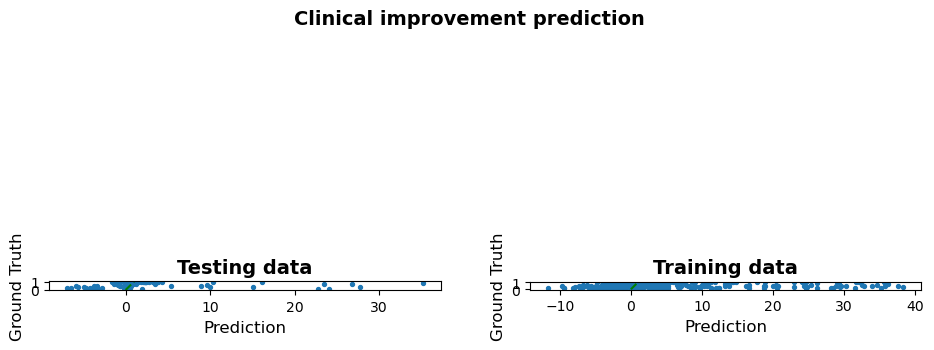

Coefficient of determination (R²):
     - testing  :     -564.0965042809408
     - training :     -534.0549410825104


In [37]:
from sklearn.svm import SVR
model = SVR(kernel='sigmoid')
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, (y_train))
plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

### RBF kernel

[0.30508178 0.92013395 0.7715173  0.98298689 0.89081956 0.47253905
 0.89327245 0.97404439 0.29696852 0.5735009  0.74017809 0.49347813
 0.90020971 0.46958644 0.97513091 1.02903036 0.8898895  0.26951183
 0.84564235 0.93594763 0.86776896 0.87510308 0.74904448 0.93014106
 0.97655634 0.93275368 0.85626871 0.7339906  0.43865707 0.86998939
 0.39662494 0.54631706 0.50260286 0.80337217 0.6328098  0.9171246
 0.92244408 0.59786811 0.26887537 0.54142328 0.6062095  0.73572947
 0.71324796 0.76942762 0.51684856 0.96634062 0.62063954 0.55500382
 0.91406071 0.9954918  0.88239403 0.30708107 0.71297001 0.58768543
 0.84236231 1.00875481 0.68468286 0.93713412 0.85532649 0.31685985
 0.73121221 1.00188595 0.86704258 0.81464639 1.00297321 0.58381113
 0.5235308  0.49009387 0.96983208 0.89701669 0.93789516 0.93606408
 1.05422737 1.02151423 0.56861228 0.35343639 0.88744529 0.96780298
 0.7616828  0.98347507 0.7649892  0.80073822 0.95013734 0.7599446
 0.34122155 0.55592828 0.66175093 1.05107556 0.59518389 0.736154

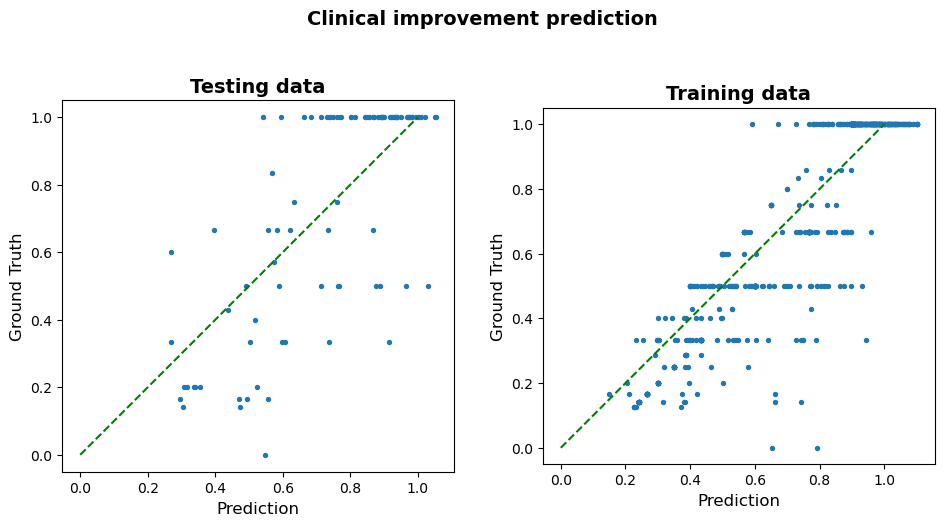

Coefficient of determination (R²):
     - testing  :     0.5359712404754433
     - training :     0.8259809063218961


In [108]:
from sklearn.svm import SVR
model = SVR(kernel='rbf', gamma='scale', tol=0.001, C=2, epsilon=0.1)
#kernel{‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’,
model = model.fit(X_train, (y_train))
plot_results(model, X_test, (y_test), X_train, (y_train), transformed=False)

## Ensembling
### Bagging Decision Tree

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[0.46779762 0.93247964 0.81167345 0.72717857 0.66445766 0.51885715
 0.9275     0.9324763  0.44273017 0.55354763 0.72577382 0.50821429
 0.95809524 0.59709424 0.95445887 0.94292857 0.97321429 0.71726361
 0.9475     0.80915619 0.93919683 0.76065238 0.87883274 0.91638889
 0.96460604 0.93672505 0.81799961 0.64441667 0.48819048 0.82307143
 0.54961905 0.81666338 0.56957143 0.87597223 0.72432727 0.94216163
 0.85815476 0.57279762 0.34517858 0.58782143 0.8448     0.62127381
 0.56564286 0.86304451 0.51429762 0.9030709  0.50125    0.79901974
 0.62733334 0.95088745 0.92260318 0.60911905 0.79359127 0.75563095
 0.93299492 0.87176191 0.66410715 0.88446565 0.89118507 0.79571429
 0.56115873 0.90842071 0.85026568 0.84646826 0.8560477  0.62146429
 0.77371135 0.61383334 0.96177328 0.88464422 0.89151707 0.94790116
 0.9629648  0.97689751 0.64877381 0.52404763 0.76638096 0.94642857
 0.727      0.93833334 0.65375    0.77838096 0.88125595 0.84992586
 0.37580953 0.57952381 0.85358417 0.80632143 0.5629762  0.8793

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s finished


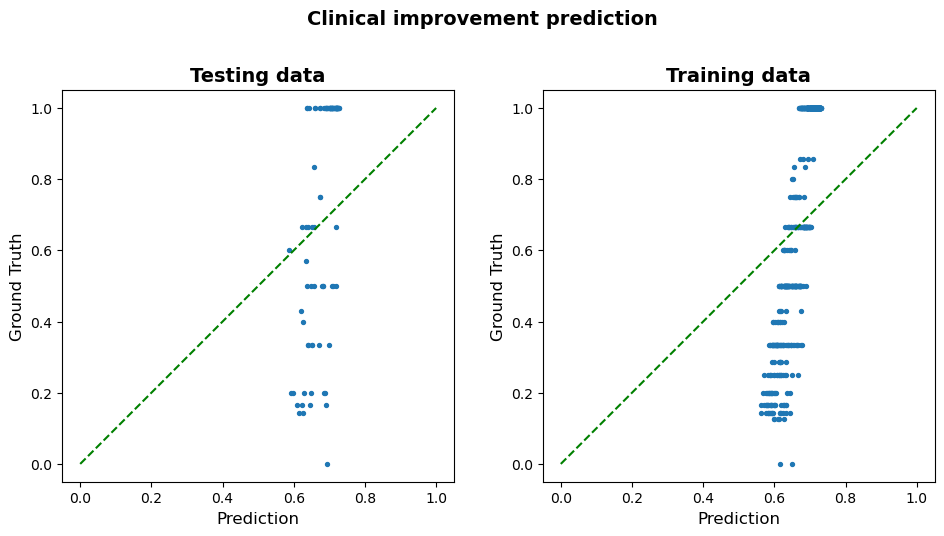

Coefficient of determination (R²):
     - testing  :     -0.5169535505939891
     - training :     -0.7318213442422141


In [106]:
from sklearn.ensemble import BaggingRegressor

model = BaggingRegressor(n_estimators=100, random_state=0, verbose=1, max_samples=0.6,bootstrap_features=True, max_features=0.2)
model = model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=True)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.linear_model import LinearSVC
from sklearn import set_config

steps = [
    ("preprocessing", StandardScaler()),
    ("classifier", LogisticRegression()),
]
pipe = Pipeline(steps)


clf = Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
  ('classification', RandomForestClassifier())
])
clf.fit(X, y)

ImportError: cannot import name 'LinearSVC' from 'sklearn.linear_model' (/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/__init__.py)

## Pipeline
### Dimensionality reduction

[0.64070854 0.86399687 0.86803953 0.67467161 0.71264024 0.44245064
 0.87471296 0.83698707 0.52664796 0.41531268 0.77057831 0.5315201
 0.89466986 0.844496   0.86831062 0.91500138 0.86784764 0.8610494
 0.90490052 0.78641198 0.85742449 0.85572952 0.8624919  0.89414744
 0.88985064 0.90074115 0.81376971 0.70418658 0.49796636 0.76293464
 0.27695887 0.81828177 0.61786213 0.92095161 0.84873759 0.85959892
 0.7221303  0.43418738 0.70916833 0.61804716 0.8969561  0.54782207
 0.49212404 0.79554086 0.65640588 0.89207012 0.73799746 0.82981452
 0.61139298 0.90723636 0.81957189 0.84746471 0.83952499 0.77642288
 0.8773037  0.86852494 0.74679727 0.91931144 0.86152525 0.77298558
 0.81676287 0.90986658 0.86727931 0.83493165 0.90321047 0.62780454
 0.82735701 0.67525971 0.86685783 0.90773644 0.81121932 0.86527245
 0.89124392 0.89291117 0.26583768 0.79707418 0.67286602 0.81720728
 0.79515175 0.86383532 0.72377553 0.86271306 0.89169162 0.85299516
 0.67214091 0.68790733 0.86071077 0.69758416 0.62096753 0.828433

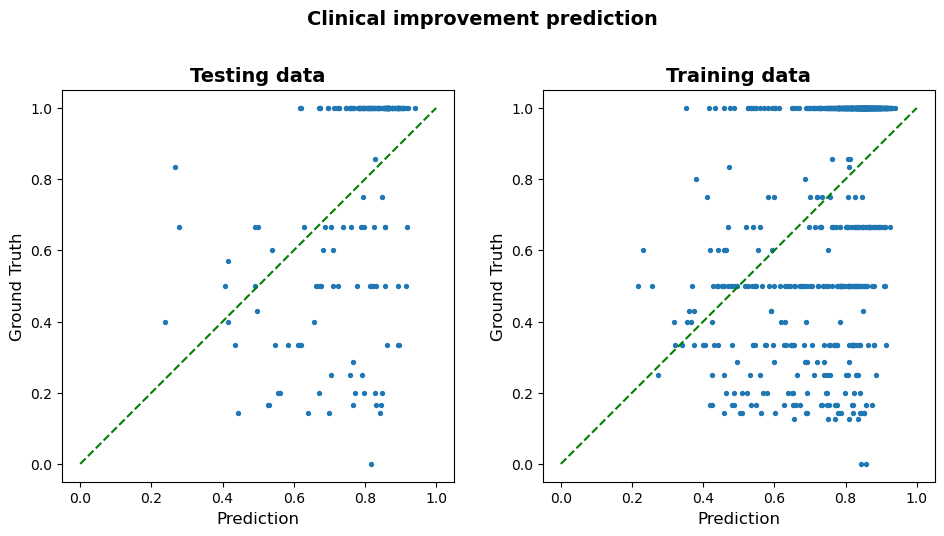

Coefficient of determination (R²):
     - testing  :     0.20850446500223985
     - training :     0.21903864444913246


In [54]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn import set_config

steps = [("reduce_dim", PCA(n_components=10)), ("regressor", BayesianRidge())]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

### Feature selection

/home/brainstimmaps/.conda/envs/PSM/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4642745768111496, tolerance: 0.03226223440663354
  positive)


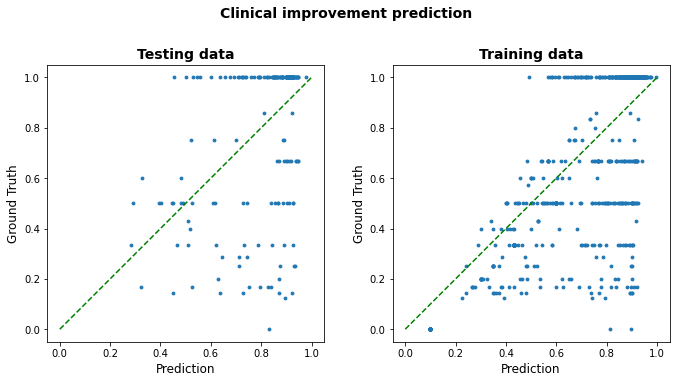

Coefficient of determination (R²):
     - testing  :     0.1261140841939672
     - training :     0.8578724947100119


AttributeError: 'Pipeline' object has no attribute 'coef_'

In [109]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import LinearSVR
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.linear_model import Lasso
from sklearn.svm import SVR

steps = [("feature selection", SelectFromModel(estimator=Lasso(alpha = 0.0001, max_iter=1e4))
), ("regressor", SVR(kernel="rbf"))]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, np.squeeze(y_train.T))
plot_results(model, X_test, y_test, X_train, y_train)
plot_map(model, dim='2D')

In [22]:
save_map(model)

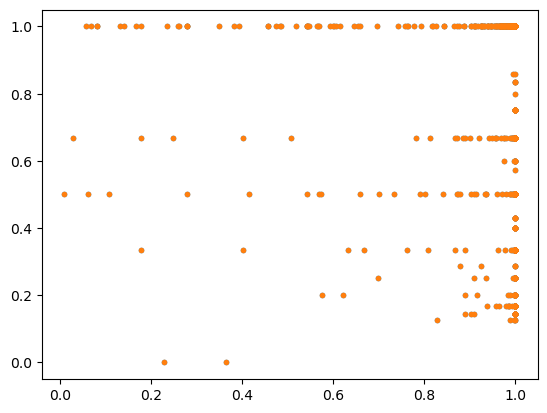

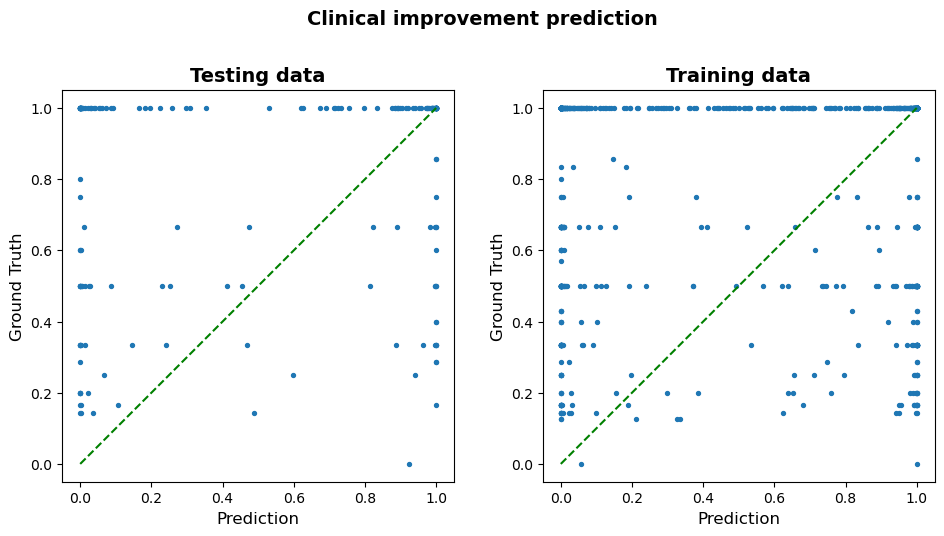

Coefficient of determination (R²):
     - testing  :     0.04072429753735051
     - training :     0.015191278492028778
Number of features selected:   n =  700


In [111]:
from scipy.optimize import minimize
from sklearn.linear_model import Lasso
from scipy.special import loggamma
from scipy.special import expit, logit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA

def logLikelihood(params, y, X):
    b = np.array(params[0:-1])      # the beta parameters of the regression model
    phi = params[-1]                # the phi parameter
    mu = expit(np.dot(X,b))

    eps = 1e-6                      # used for safety of the gamma and log functions avoiding inf
    res = - np.sum(loggamma(phi+eps) # the log likelihood
                   - loggamma(mu*phi+eps)
                   - loggamma((1-mu)*phi+eps)
                   + (mu*phi-1)*np.log(y+eps)
                   + ((1-mu)*phi-1)*np.log(1-y+eps))

    return res

def penalty(params, C=0, C1_ratio=0.5):
    return C * C1_ratio * np.linalg.norm(params, ord=1, axis=0) + C * (1 - C1_ratio) * np.linalg.norm(params, ord=2, axis=0)

def costFunction(params, y, X):
    return logLikelihood(params, y, X) + penalty(params)

# feature_selection = VarianceThreshold()
feature_selection = PCA(n_components=700)
feature_selection = feature_selection.fit(X_train)


X_train_selected_feat = feature_selection.transform(X_train)
X_test_selected_feat = feature_selection.transform(X_test)

x0 = np.ones(X_train_selected_feat.shape[1] + 1)
bounds = ((None, None),) * X_train_selected_feat.shape[1] + ((0, None),)
options = {"disp": True}

res = minimize(costFunction, x0=x0, args=(np.squeeze(y_train), X_train_selected_feat), bounds=bounds, options=options)

b = np.array(res.x[0:X_train_selected_feat.shape[1]])   # optimal regression parameters
pred_train = expit(np.dot(X_train_selected_feat, b))             # prediction
pred_test = expit(np.dot(X_test_selected_feat, b))             # predictions

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_test, y_test)
coef_deter_test = r_value**2

slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(pred_train, y_train)
coef_deter_train = r_value**2

# Create figure and axes
fig, axs = plt.subplots(1, 2)

# Set figure size and name
fig.tight_layout()
fig.suptitle('Clinical improvement prediction', y=0.8, fontsize=14, fontweight='bold')
fig.set_size_inches(25/2.54, 25/2.54)

# Set axe properties
axs[0].set_title('Testing data', fontdict=FONT_TITLE_PLOT)
axs[0].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[0].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[0].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[0].scatter(pred_test, y_test, s=8)
axs[0].set_aspect('equal', 'box')
axs[0].set_xlim([-0.05, 1.05])
axs[0].set_ylim([-0.05, 1.05])

axs[1].set_title('Training data', fontdict=FONT_TITLE_PLOT)
axs[1].plot((0, 1), (0, 1), color='green', linestyle='dashed', linewidth=1.5)
axs[1].set_xlabel('Prediction', fontdict=FONT_LABEL_PLOT)
axs[1].set_ylabel('Ground Truth', fontdict=FONT_LABEL_PLOT)
axs[1].scatter(pred_train, y_train, s=8)
axs[1].set_aspect('equal', 'box')
axs[1].set_xlim([-0.05, 1.05])
axs[1].set_ylim([-0.05, 1.05])

# Show figure
plt.show()

# Print the value of the R2
print("Coefficient of determination (R²):")
print("     - testing  :    ", coef_deter_test)
print("     - training :    ", coef_deter_train)

# Print the value of the R2
print("Number of features selected:   n = ", X_train_selected_feat.shape[1])

## PCA feature reduction

[ 9.10364358e-01  8.50861463e-01  8.05291222e-01  7.13903640e-01
  7.71769913e-01  9.75183604e-01  7.22709303e-01  8.03381107e-01
  4.42386055e-01  6.10648065e-01  7.35242918e-01  7.70813678e-01
  9.35069276e-01  9.29852554e-01  8.81919981e-01 -3.25293072e+09
  9.11533341e-01  9.87896937e-01  7.53440058e-01  8.28800679e-01
  6.50822084e-01  8.20445743e-01  8.18985437e-01  7.21478806e-01
 -1.82747943e+07  6.68230044e-01  9.13720182e-01  8.13746521e-01
 -4.03758263e+01  8.48110858e-01  8.31180465e-01  3.12997042e-01
  7.92994003e-01  9.56388031e-01  8.64983784e-01  7.59080163e-01
  2.03930330e+06  8.75981513e-01  4.84976839e-01  7.35391813e-01
  8.16992684e-01  6.97245962e-01  8.96272612e-01  9.20584608e-02
  8.22924074e-01  6.68744648e-01  9.47933316e-01  9.74532430e-01
  8.67273576e-01  7.90131508e-01  3.92283309e-01  3.81715270e+02
  7.45657349e-01  7.75039532e-01  7.82556870e-01  1.81500376e+04
  8.59698132e-01  1.19782266e+00  9.93634445e-01  9.84860813e-01
  7.07994220e-01  8.80311

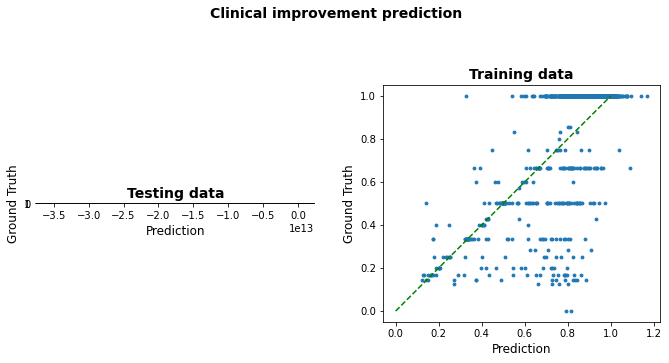

Coefficient of determination (R²):
     - testing  :     -7.216892805035788e+25
     - training :     0.49198624404847513


ValueError: cannot reshape array of size 198 into shape (29,31,32)

In [231]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

from sklearn.decomposition import PCA




steps = [("preproc", StandardScaler()), ("reduce_dim", PCA(n_components=200)), ("regressor", LinearRegression())]
model = Pipeline(steps)
set_config(display="diagram")
model.fit(X_train, y_train)
plot_results(model, X_test, y_test, X_train, y_train, transformed=False)

plot_map(model.named_steps['regressor'])

[[ 1.02570713e+00]
 [ 6.70367303e-01]
 [ 1.10883147e+00]
 [ 6.72465759e-01]
 [ 6.39497894e-01]
 [ 6.75803613e-01]
 [ 7.94529685e-01]
 [ 8.49384302e-01]
 [ 5.02697093e-01]
 [ 4.21066751e-01]
 [ 6.02370701e-01]
 [ 9.45473611e-01]
 [ 9.79555448e-01]
 [ 7.53295239e-01]
 [ 8.88404197e-01]
 [ 3.19831010e+11]
 [ 1.22190618e+00]
 [ 1.15578238e+00]
 [ 9.85016905e-01]
 [ 7.59420523e-01]
 [ 5.01265094e-01]
 [ 8.37594159e-01]
 [ 9.71713248e-01]
 [ 1.18161613e+00]
 [ 1.18898792e+10]
 [ 3.14928003e-01]
 [ 8.18209607e-01]
 [ 7.91265604e-01]
 [-2.20895924e+02]
 [ 2.91824134e-01]
 [ 8.71050571e-01]
 [-7.15763152e-02]
 [ 1.02641148e+00]
 [ 1.02512493e+00]
 [ 8.08927047e-01]
 [ 8.45714507e-01]
 [ 4.89293249e+04]
 [ 7.53799659e-01]
 [ 5.14185774e-01]
 [ 7.76749833e-01]
 [ 9.07111706e-01]
 [ 7.12925264e-01]
 [ 8.30730912e-01]
 [ 1.22548438e+02]
 [ 1.10854063e+00]
 [ 4.88037300e-01]
 [ 7.90875085e-01]
 [ 1.06508422e+00]
 [ 1.00229838e+00]
 [ 9.81929146e-01]
 [ 4.72638700e-01]
 [ 1.55682455e+01]
 [ 4.3839929

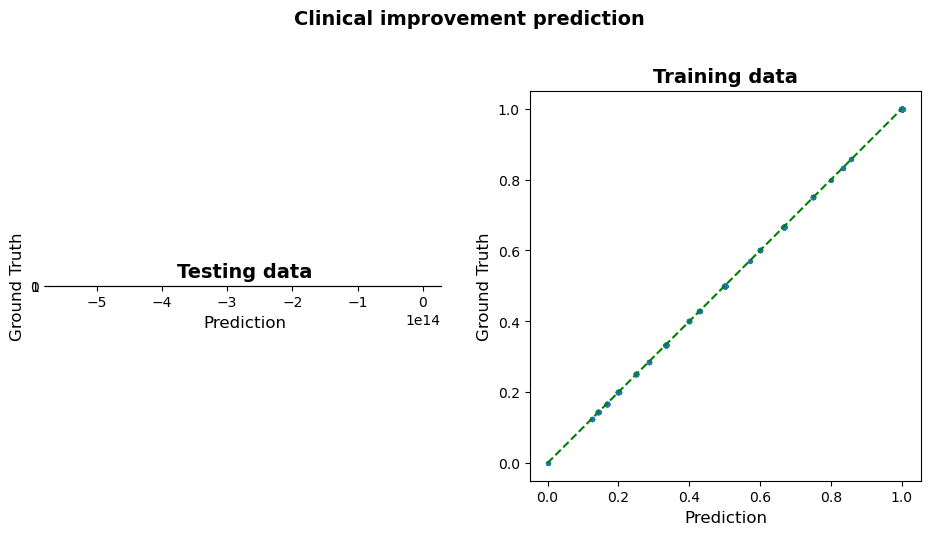

Coefficient of determination (R²):
     - testing  :     -1.7310103433042793e+28
     - training :     0.9999982183817282
5


TypeError: 'PLSRegression' object is not subscriptable

In [112]:
from sklearn.cross_decomposition import PLSRegression

pls = PLSRegression(n_components=200)
pls.fit(X_train, y_train)
plot_results(pls, X_test, y_test, X_train, y_train, transformed=False)

plot_map(pls)